In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.python.compiler.tensorrt import trt_convert as trt
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# input_saved_model_dir = 'data/models/efficientdet_d6_coco17_tpu-32/saved_model/'
input_saved_model_dir = 'data/mobilenetssd_v2_fpn_lite/'
output_saved_model_dir = 'data/ssd-tensorRT/'
num_runs = 2

conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS
conversion_params = conversion_params._replace(max_workspace_size_bytes=(1<<32))
conversion_params = conversion_params._replace(precision_mode="FP16")
# conversion_params = conversion_params._replace(maximum_cached_engiens=100)

converter = trt.TrtGraphConverterV2(input_saved_model_dir=input_saved_model_dir,conversion_params=conversion_params)
trt_model = converter.convert()

def my_input_fn():
    for _ in range(num_runs):
        inp1 = np.random.normal(size=(1, 640, 640, 3)).astype(np.uint8)
        yield inp1
        
converter.build(input_fn=my_input_fn)
converter.save(output_saved_model_dir)

2023-05-16 10:18:01.339660: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-16 10:18:01.360900: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-05-16 10:18:02.254055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 10:18:02.264991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 10:18:02.265026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 10:18:02.269274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 10:18:02.269319: I tensorflow/compile

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-05-16 10:18:11.575913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 10:18:11.575958: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-16 10:18:11.576036: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-16 10:18:11.576239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 10:18:11.576265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 10:18:11.576277: I tensor

INFO:tensorflow:Assets written to: data/ssd-tensorRT/assets


In [2]:
import os
os.environ["TFHUB_CACHE_DIR"]="/home/singularity108/.cache/tfhub_modules"
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

# import tensorflow as tf
# import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [3]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        print(image_data)
        image = Image.open(BytesIO(image_data))

    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (1, im_height, im_width, 3)).astype(np.uint8)

IMAGES_FOR_TEST = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



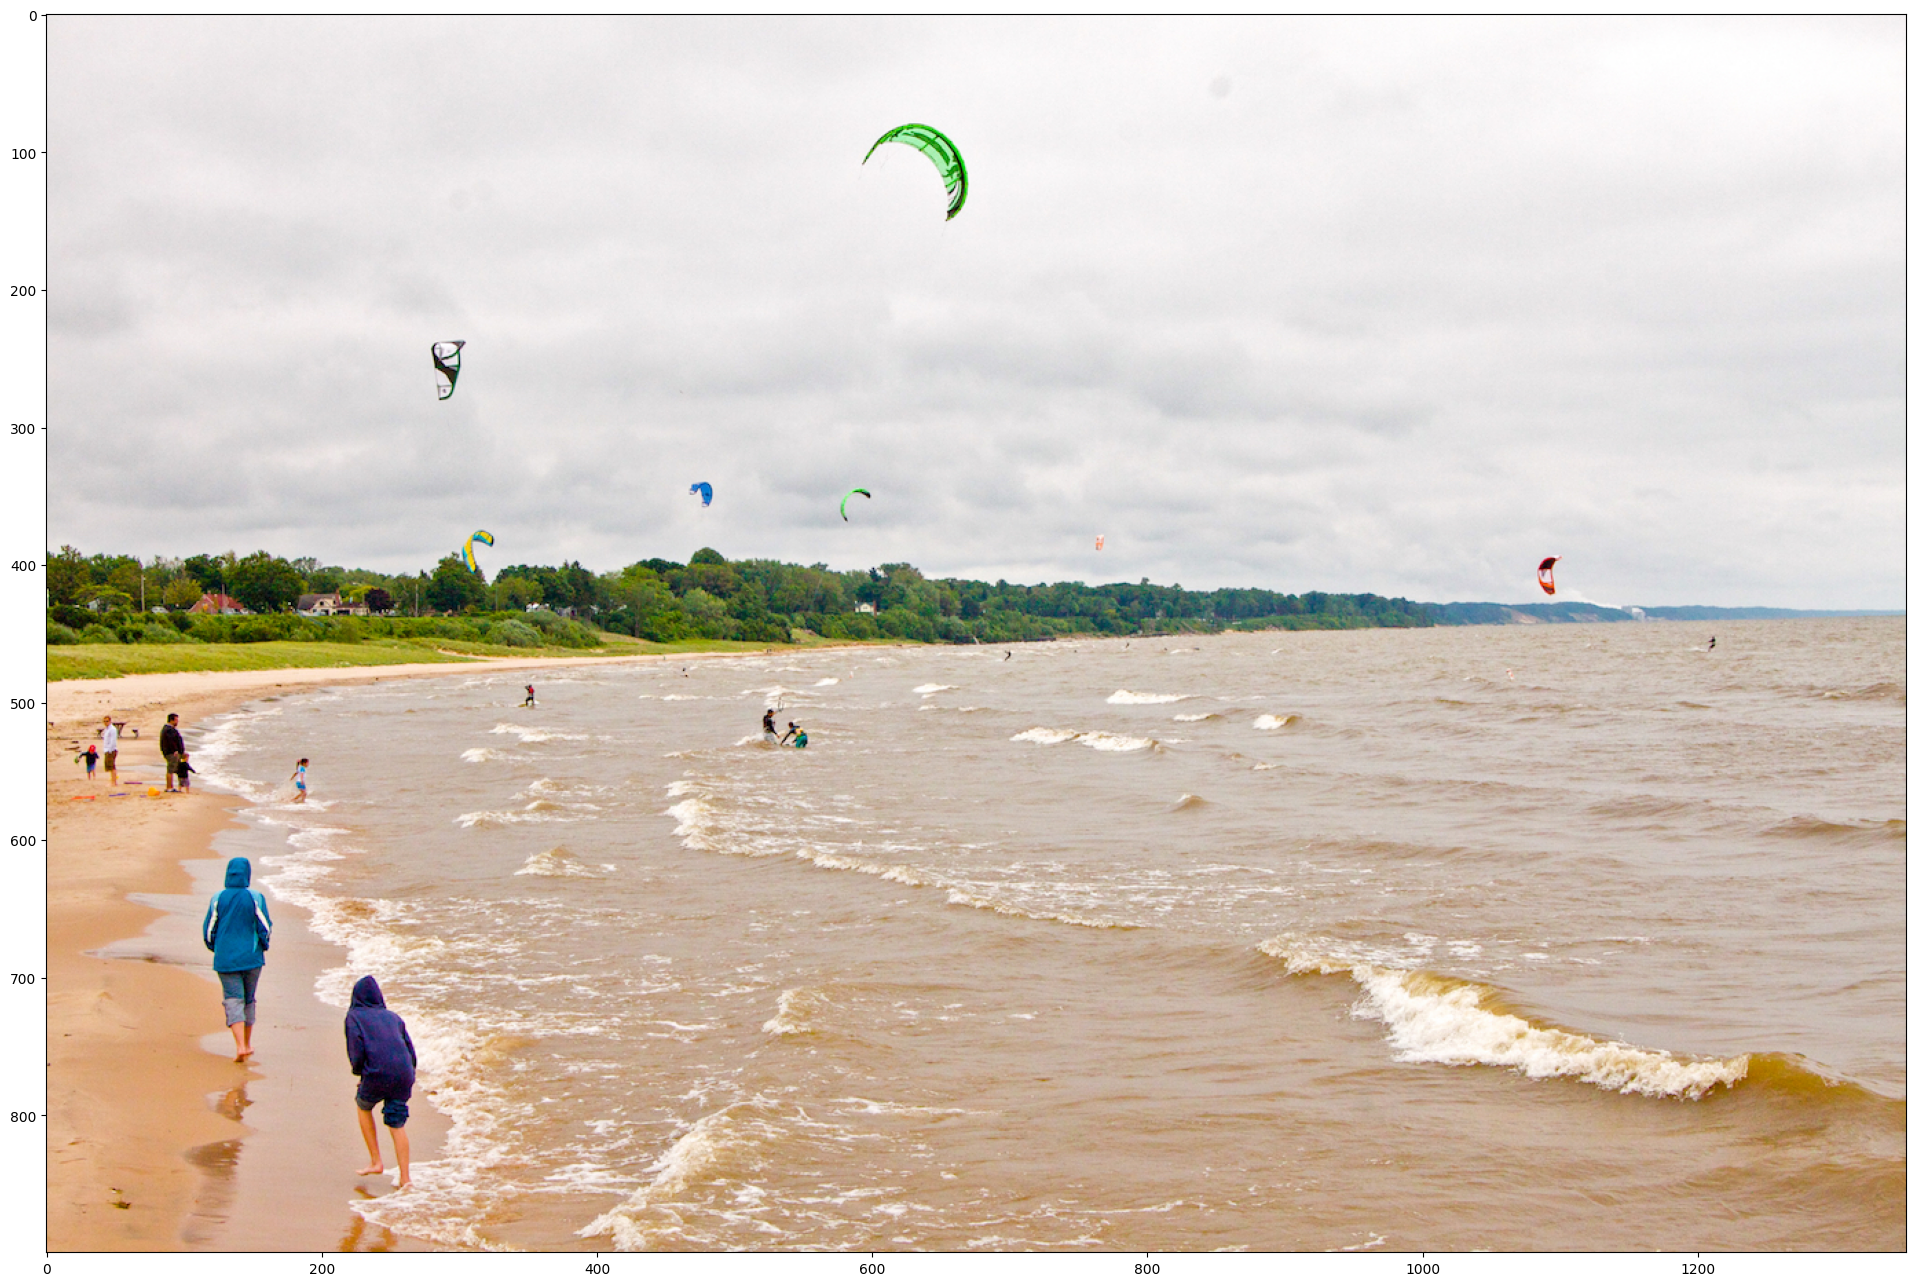

In [4]:
#@title Image Selection (don't forget to execute the cell!) { display-mode: "form"}
selected_image = 'Beach' # @param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
flip_image_horizontally = False #@param {type:"boolean"}
convert_image_to_grayscale = False #@param {type:"boolean"}

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
    image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
    image_np[0] = np.tile(
        np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

In [6]:
trt_model(image_np)

TypeError: pruned(input_tensor): expected argument #0(zero-based) to be a Tensor; got ndarray ([[[[232 228 229]
   [236 232 233]
   [235 231 232]
   ...
   [241 239 240]
   [241 239 240]
   [240 238 239]]

  [[236 232 233]
   [237 233 234]
   [237 233 234]
   ...
   [240 238 239]
   [242 240 241]
   [241 239 240]]

  [[236 232 233]
   [236 232 233]
   [235 231 232]
   ...
   [244 240 241]
   [242 238 239]
   [245 241 242]]

  ...

  [[223 171 124]
   [227 173 129]
   [226 168 128]
   ...
   [179 145 108]
   [182 147 109]
   [176 136 100]]

  [[221 168 124]
   [224 170 126]
   [230 173 128]
   ...
   [184 148 112]
   [176 139 110]
   [187 150 124]]

  [[227 176 133]
   [227 173 129]
   [230 173 128]
   ...
   [181 141 115]
   [190 153 124]
   [188 154 127]]]]).